In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import joblib

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH   = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/'
FIGURES_PATH = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/'
MODELS_PATH = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
train_df = pd.read_parquet(DATA_PATH + 'baseline_training.parquet')
test_df  = pd.read_parquet(DATA_PATH + 'baseline_testing.parquet')

print(f'Train shape : {train_df.shape}')
print(f'Test  shape : {test_df.shape}')
print(f'\nClass distribution (train):')
print(train_df['revenue_class'].value_counts().sort_index())

Train shape : (233850, 44)
Test  shape : (39445, 44)

Class distribution (train):
revenue_class
1    26850
2    51162
3    51092
4    51808
5    52938
Name: count, dtype: int64


In [5]:
TARGET_COL = 'revenue_class'

COLS_TO_EXCLUDE = [TARGET_COL, 'timestamp', 'hour', 'day_of_week']

X_train = train_df.drop(columns=COLS_TO_EXCLUDE)
y_train = train_df[TARGET_COL]

X_test  = test_df.drop(columns=COLS_TO_EXCLUDE)
y_test  = test_df[TARGET_COL]


CATEGORICAL_FEATURES = ['pickup_cluster']
NUMERIC_FEATURES = [
    col for col in X_train.select_dtypes(include=np.number).columns
    if col not in CATEGORICAL_FEATURES
]

# Pipeline

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    f1_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(random_state=RANDOM_STATE), CATEGORICAL_FEATURES),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [8]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1,
    )),
])

full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  TargetEncoder(random_state=42),
                                                  ['pickup_cluster'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20, min_samples_leaf=5,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42, verbose=1))])

In [9]:
n_trees = full_pipeline.named_steps['classifier'].n_estimators
print(f'Training Random Forest on {X_train.shape[0]:,} samples, {X_train.shape[1]} features...')
print(f'Building {n_trees} trees in parallel across all CPU cores.\n')

t0 = time.time()
full_pipeline.fit(X_train, y_train)
train_time = time.time() - t0

Training Random Forest on 233,850 samples, 40 features...
Building 500 trees in parallel across all CPU cores.



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.7min finished


In [10]:
y_pred = full_pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_mae      = mean_absolute_error(y_test, y_pred)
adjacent_acc  = np.mean(np.abs(y_test - y_pred) <= 1)
weighted_f1   = f1_score(y_test, y_pred, average='weighted')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    5.6s finished


In [11]:
CLASS_LABELS = ['1: Very Low', '2: Low', '3: Medium', '4: High', '5: Very High']

In [12]:
print('=' * 60)
print('  Test Set Evaluation — Random Forest')
print('=' * 60)
print(f'  Accuracy               : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'  MAE (ordinal)          : {test_mae:.4f}   [target: ≤ 0.80]')
print(f'  Adjacent Accuracy (±1) : {adjacent_acc:.4f} ({adjacent_acc*100:.2f}%)  [target: ≥ 90%]')
print(f'  Weighted F1            : {weighted_f1:.4f}   [target: ≥ 0.75]')
print('=' * 60)
print()
print('Per-class Report:')
print(classification_report(y_test, y_pred, target_names=CLASS_LABELS))

  Test Set Evaluation — Random Forest
  Accuracy               : 0.7841 (78.41%)
  MAE (ordinal)          : 0.2194   [target: ≤ 0.80]
  Adjacent Accuracy (±1) : 0.9972 (99.72%)  [target: ≥ 90%]
  Weighted F1            : 0.7838   [target: ≥ 0.75]

Per-class Report:
              precision    recall  f1-score   support

 1: Very Low       0.72      0.71      0.72      2753
      2: Low       0.77      0.78      0.78      8705
   3: Medium       0.75      0.73      0.74      9755
     4: High       0.76      0.77      0.76      9462
5: Very High       0.88      0.89      0.88      8770

    accuracy                           0.78     39445
   macro avg       0.78      0.78      0.78     39445
weighted avg       0.78      0.78      0.78     39445



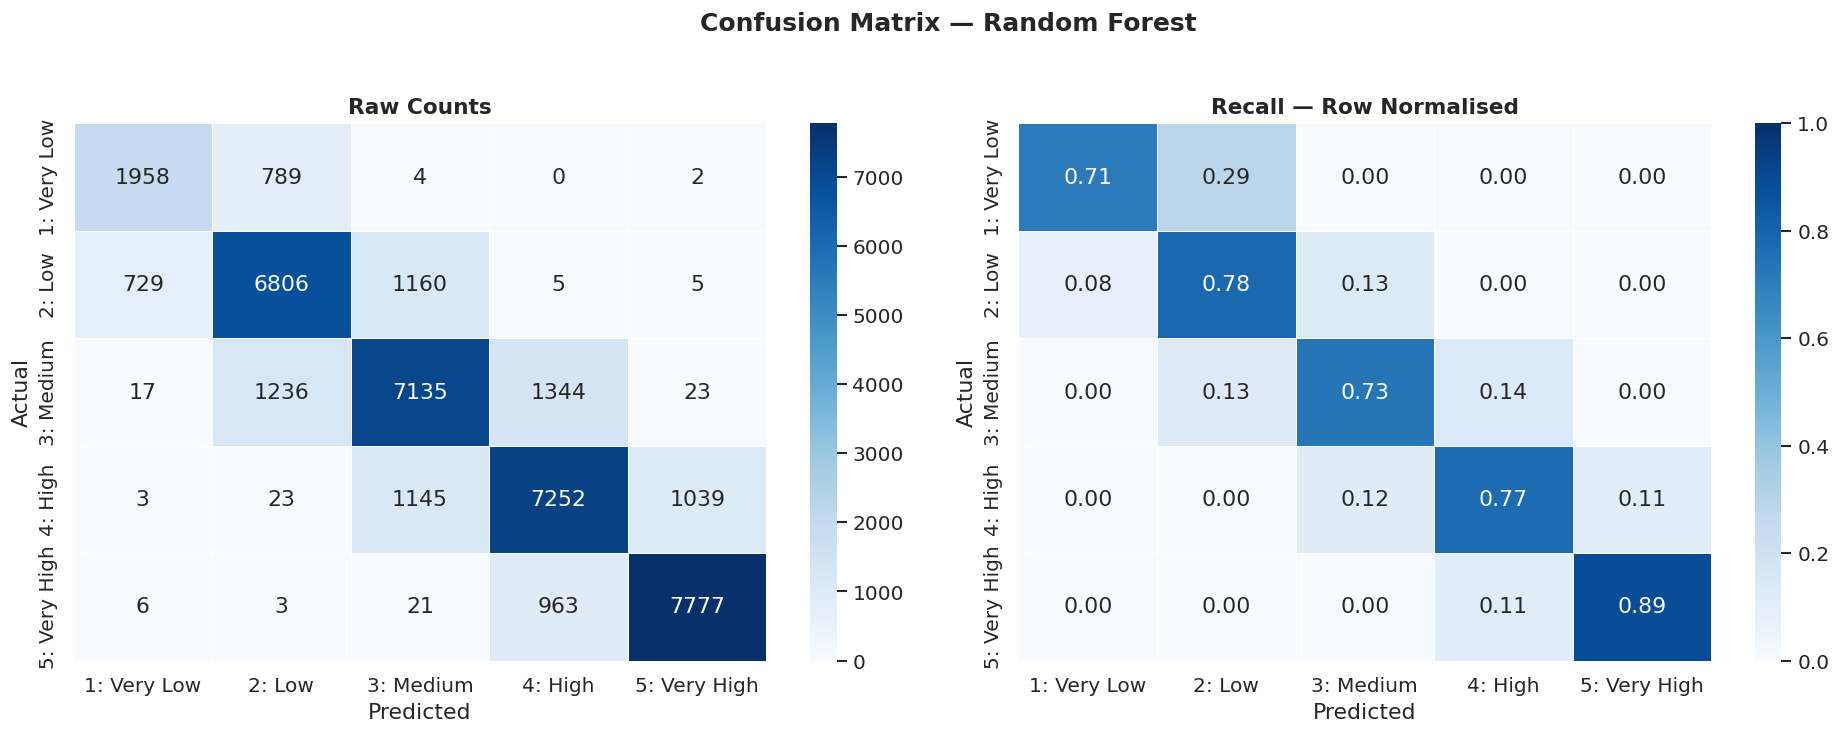

In [13]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
    ax=axes[0], linewidths=0.5,
)
axes[0].set_title('Raw Counts', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(
    cm_norm, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
    ax=axes[1], linewidths=0.5, vmin=0, vmax=1,
)
axes[1].set_title('Recall — Row Normalised', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrix — Random Forest', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

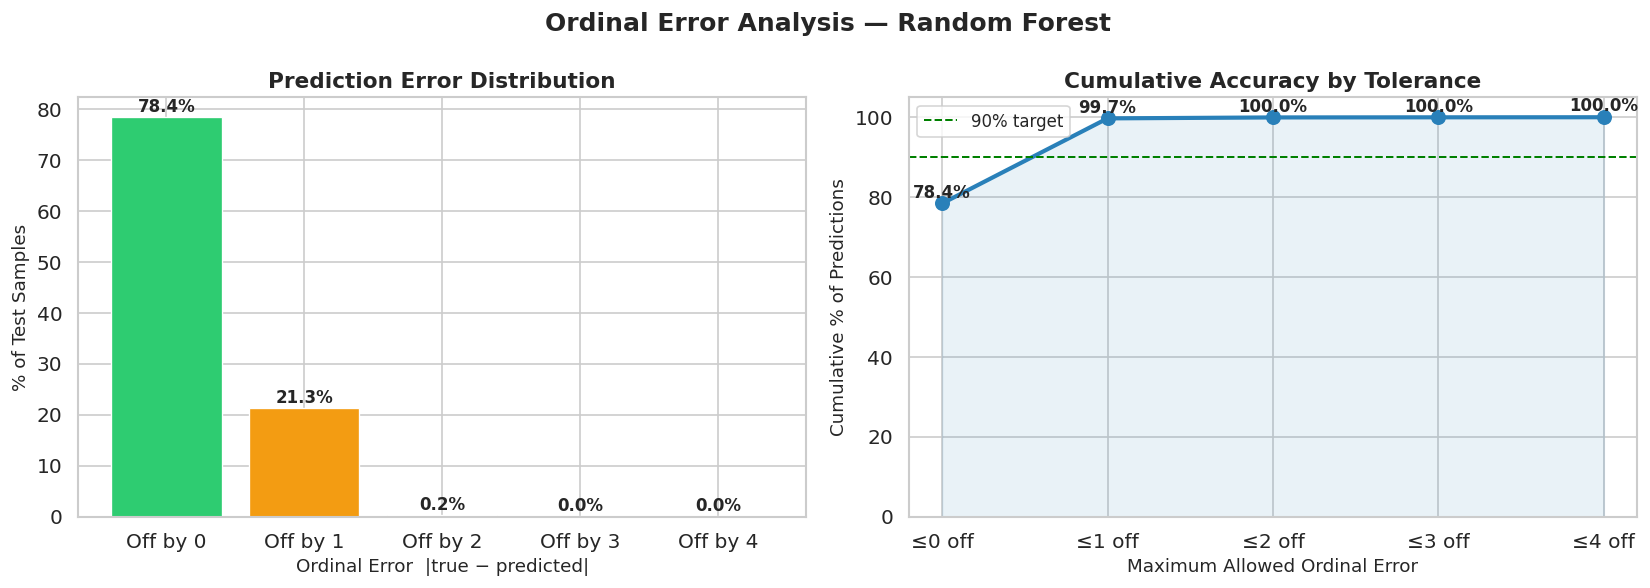

  Exact match           : 78.4%
  Within ±1 class       : 99.7%
  Within ±2 classes     : 100.0%


In [14]:
errors       = np.abs(y_test.values - y_pred)
error_counts = pd.Series(errors).value_counts().sort_index()
error_pct    = error_counts / len(errors) * 100
cum_pct      = error_pct.cumsum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error magnitude bar chart
palette = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
bars = axes[0].bar(
    error_pct.index, error_pct.values,
    color=palette[:len(error_pct)], edgecolor='white', linewidth=0.8
)
axes[0].set_xlabel('Ordinal Error  |true − predicted|', fontsize=11)
axes[0].set_ylabel('% of Test Samples', fontsize=11)
axes[0].set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
axes[0].set_xticks(error_pct.index)
axes[0].set_xticklabels([f'Off by {i}' for i in error_pct.index])
for bar, pct in zip(bars, error_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# cumulative accuracy curve
axes[1].plot(cum_pct.index, cum_pct.values, marker='o', color='#2980b9',
             linewidth=2.5, markersize=8)
axes[1].axhline(90, color='green', linestyle='--', linewidth=1.2, label='90% target')
axes[1].fill_between(cum_pct.index, cum_pct.values, alpha=0.1, color='#2980b9')
axes[1].set_xlabel('Maximum Allowed Ordinal Error', fontsize=11)
axes[1].set_ylabel('Cumulative % of Predictions', fontsize=11)
axes[1].set_title('Cumulative Accuracy by Tolerance', fontsize=13, fontweight='bold')
axes[1].set_xticks(cum_pct.index)
axes[1].set_xticklabels([f'≤{i} off' for i in cum_pct.index])
axes[1].set_ylim(0, 105)
axes[1].legend(fontsize=10)
for x, y in zip(cum_pct.index, cum_pct.values):
    axes[1].text(x, y + 1.5, f'{y:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Ordinal Error Analysis — Random Forest', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'  Exact match           : {error_pct.get(0, 0):.1f}%')
print(f'  Within ±1 class       : {cum_pct.get(1, 0):.1f}%')
print(f'  Within ±2 classes     : {cum_pct.get(2, 0):.1f}%')

/tmp/ipython-input-2621001362.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


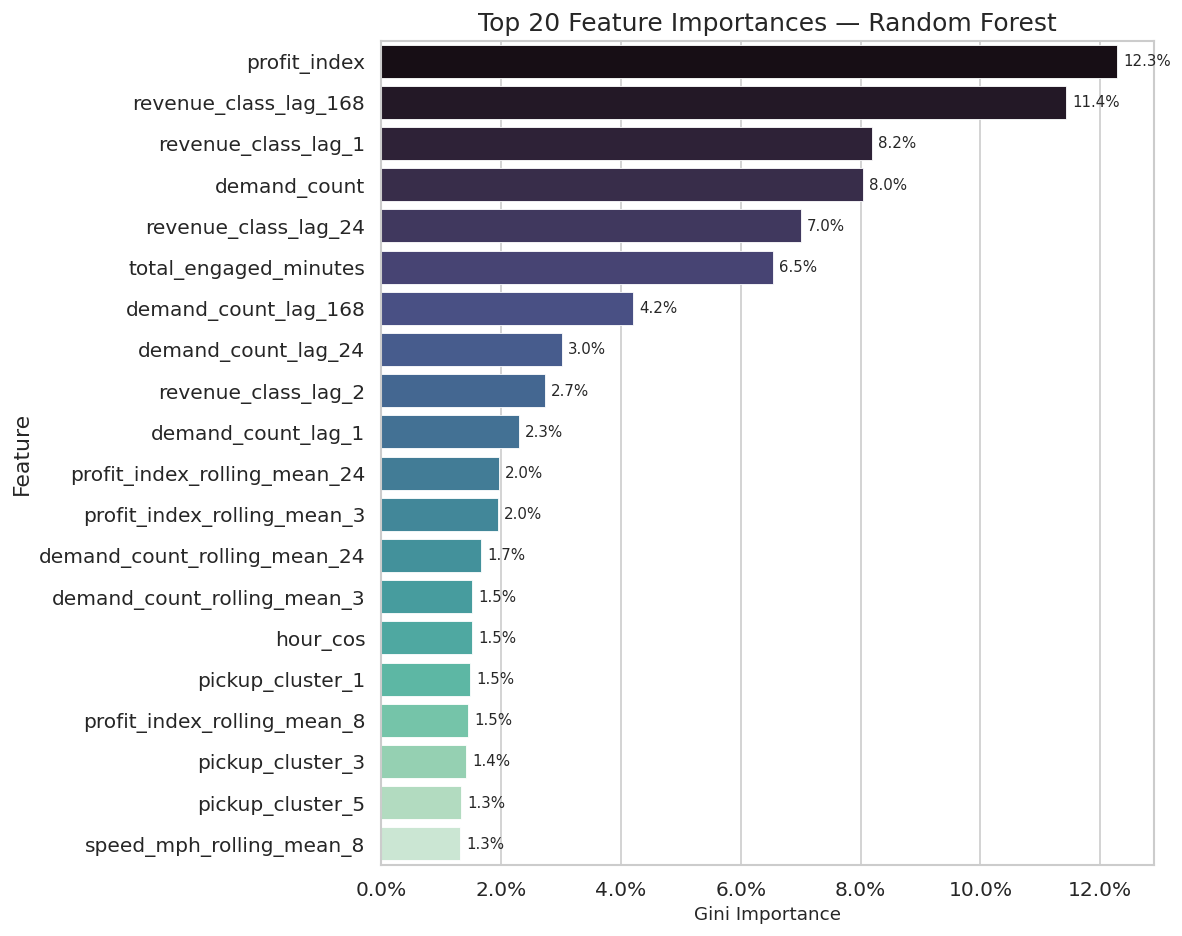

Top 5 features account for 46.9% of total importance


In [15]:
feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances   = full_pipeline.named_steps['classifier'].feature_importances_

imp_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

TOP_N   = 20
top_imp = imp_df.head(TOP_N)
# Sort for sns.barplot to display in ascending order for horizontal bars
top_imp_sorted = top_imp.sort_values('Importance', ascending=False)

# Generate colors for the bars, ensuring they align with the sorted order if a gradient is desired
colors  = sns.color_palette("mako", n_colors=TOP_N)

fig, ax = plt.subplots(figsize=(10, 8))

# Use seaborn.barplot for a prettier plot
bars = sns.barplot(
    x='Importance',
    y='Feature',
    data=top_imp_sorted,
    palette=colors, # Apply the generated color palette
    edgecolor='white',
    linewidth=0.5,
    ax=ax
)

# Add text labels to the bars
for bar in bars.patches:
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height() / 2,
            f'{width*100:.1f}%', va='center', fontsize=9)

ax.set_xlabel('Gini Importance', fontsize=11)
ax.set_title(f'Top {TOP_N} Feature Importances — Random Forest', fontsize=15)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.grid(axis='y', visible=False) # Turn off only horizontal grid lines
plt.tight_layout()
plt.show()

print(f'Top 5 features account for {imp_df["Importance"].head(5).sum()*100:.1f}% of total importance')

In [17]:
model_save_path = MODELS_PATH + 'rf_best_model.pkl'
joblib.dump(full_pipeline, model_save_path)

['/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/rf_best_model.pkl']